In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Projects/CustomerSegementation/data.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Data Wrangling

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [8]:
print("Information of data :")
print("Total Row \t\t:", df.shape[0]) #check total rows in data
print("Total Column \t\t:", df.shape[1]) #check total coloumns in data
print("Date range from \t:", df.InvoiceDate.min(), " to ", df.InvoiceDate.max()) #check date range in data
print("#Invoice No. \t\t:", df.InvoiceNo.nunique()) #check invoice no.
print("#Unique Customer \t:", df.CustomerID.nunique()) #check unique customer
print("Range Quantity \t\t:", df.Quantity.min(), " to ", df.Quantity.max()) #check range Quantity in data
print("Range UnitPrice \t:", df.UnitPrice.min(), " to ", df.UnitPrice.max()) #check range UnitPrice in data

Information of data :
Total Row 		: 541909
Total Column 		: 8
Date range from 	: 2010-12-01 08:26:00  to  2011-12-09 12:50:00
#Invoice No. 		: 25900
#Unique Customer 	: 4372
Range Quantity 		: -80995  to  80995
Range UnitPrice 	: -11062.06  to  38970.0


In [9]:
print(df.isnull().sum().sort_values(ascending=False))

CustomerID     135080
Description      1454
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64


In [10]:
df_new = df.dropna() ## remove null
df_new = df_new[df_new.Quantity > 0] ## remove negative value in Quantity column
df_new = df_new[df_new.UnitPrice > 0] ## remove negative value in UnitPrice column

In [11]:
print(df_new.isnull().sum().sort_values(ascending=False))

Country        0
CustomerID     0
UnitPrice      0
InvoiceDate    0
Quantity       0
Description    0
StockCode      0
InvoiceNo      0
dtype: int64


In [12]:
df_new['Revenue'] = df_new['Quantity'] * df_new['UnitPrice'] ## add Revenue (Qty * UnitPrice) column
df_new['CustomerID'] = df_new['CustomerID'].astype('int64') #change format CustomerID

##RFM Analysis

In [13]:
import datetime as dt
NOW = dt.datetime(2011,12,10)

In [14]:
rfmTable = df_new.groupby(['CustomerID'],as_index=False).agg({'InvoiceDate': lambda x: (NOW - x.max()).days, 'InvoiceNo': lambda x: len(x), 'Revenue': lambda x: x.sum()})
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'Revenue': 'Monetary'}, inplace=True)

In [15]:
rfmTable.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12347,2,182,4310.00
2,12348,75,31,1797.24
3,12349,18,73,1757.55
4,12350,310,17,334.40


In [16]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
segmented_rfm = rfmTable

In [17]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [18]:
segmented_rfm['r_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles,))
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile
0,12346,325,1,77183.60,1,1,4
1,12347,2,182,4310.00,4,4,4
2,12348,75,31,1797.24,2,2,4
3,12349,18,73,1757.55,3,3,4
4,12350,310,17,334.40,1,1,2


In [19]:
segmented_rfm['RFM_Segement'] = segmented_rfm.r_quartile.map(str)+segmented_rfm.f_quartile.map(str)+segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Segement
0,12346,325,1,77183.60,1,1,4,114
1,12347,2,182,4310.00,4,4,4,444
2,12348,75,31,1797.24,2,2,4,224
3,12349,18,73,1757.55,3,3,4,334
4,12350,310,17,334.40,1,1,2,112


In [20]:
segmented_rfm['RFM_Score'] = segmented_rfm[['r_quartile','f_quartile','m_quartile']].sum(axis=1)
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Segement,RFM_Score
0,12346,325,1,77183.60,1,1,4,114,6
1,12347,2,182,4310.00,4,4,4,444,12
2,12348,75,31,1797.24,2,2,4,224,8
3,12349,18,73,1757.55,3,3,4,334,10
4,12350,310,17,334.40,1,1,2,112,4


###Top 5 Customer based on RFMScore


In [21]:
top_customer = df_new[df_new['CustomerID'] == 14646]
top_customer.head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
37952,539491,21981,PACK OF 12 WOODLAND TISSUES,12,2010-12-20 10:09:00,0.29,14646,Netherlands,3.48
37953,539491,21986,PACK OF 12 PINK POLKADOT TISSUES,12,2010-12-20 10:09:00,0.29,14646,Netherlands,3.48
37954,539491,22720,SET OF 3 CAKE TINS PANTRY DESIGN,2,2010-12-20 10:09:00,4.95,14646,Netherlands,9.90
37955,539491,21931,JUMBO STORAGE BAG SUKI,1,2010-12-20 10:09:00,1.95,14646,Netherlands,1.95
37956,539491,22613,PACK OF 20 SPACEBOY NAPKINS,2,2010-12-20 10:09:00,0.85,14646,Netherlands,1.70
37957,539491,20751,FUNKY WASHING UP GLOVES ASSORTED,1,2010-12-20 10:09:00,2.10,14646,Netherlands,2.10
37958,539491,21246,RED RETROSPOT BIG BOWL,2,2010-12-20 10:09:00,4.95,14646,Netherlands,9.90
37959,539491,22960,JAM MAKING SET WITH JARS,1,2010-12-20 10:09:00,4.25,14646,Netherlands,4.25
37960,539491,22355,CHARLOTTE BAG SUKI DESIGN,2,2010-12-20 10:09:00,0.85,14646,Netherlands,1.70
37961,539491,21123,SET/10 IVORY POLKADOT PARTY CANDLES,2,2010-12-20 10:09:00,1.25,14646,Netherlands,2.50


In [22]:
data = segmented_rfm.copy()

In [23]:
data.head()

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Segement,RFM_Score
0,12346,325,1,77183.60,1,1,4,114,6
1,12347,2,182,4310.00,4,4,4,444,12
2,12348,75,31,1797.24,2,2,4,224,8
3,12349,18,73,1757.55,3,3,4,334,10
4,12350,310,17,334.40,1,1,2,112,4


## Preprocessing data for Clustering
In the next section, we are going to prepare the data for Kmeans clustering on RFM Score data. To do this, we need to preprocess the data so that it can meet the key assumptions of Kmeans algorithm, which are:

The varaiables should be distributed symmetrically
Variables should have similar average values
Variables should have similar standard deviation values[link text](https://)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

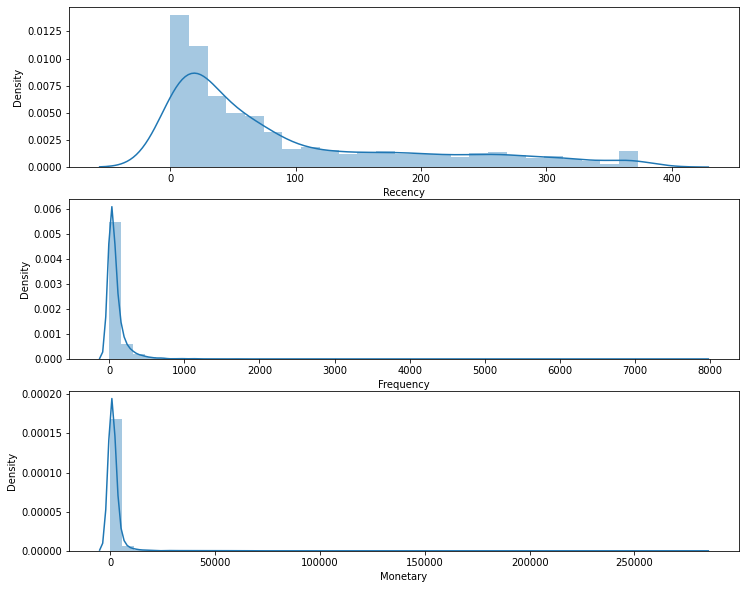

In [24]:
# Checking the distribution of Recency, Frequency and MonetaryValue variables.
plt.figure(figsize=(12,10))

# Plot distribution of var1
plt.subplot(3, 1, 1); sns.distplot(data['Recency'])

# Plot distribution of var2
plt.subplot(3, 1, 2); sns.distplot(data['Frequency'])

# Plot distribution of var3
plt.subplot(3, 1, 3); sns.distplot(data['Monetary'])


As we can see from the above plots, all the variables do not have a symmetrical distribution. All of them are skewed to the right. To remove the skewness, we can try the following transformations:

log transformations
Box-Cox transformations
Cube root transformations
The log transformation cannot be used for negative values. One common practice one can use here is to add a constant value to get a positive value and this is generally taken as the absolute of the least negative value of the variable to each observation. However, in our data, we do not have any negative values since we are dealing with customer transactions dataset.

In [25]:
# Checking for constant mean and variance.
data[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.059474,91.720609,2054.266460
std,100.012264,228.785094,8989.230441
min,0.000000,1.000000,3.750000
25%,17.000000,17.000000,307.415000
50%,50.000000,41.000000,674.485000
75%,141.750000,100.000000,1661.740000
max,373.000000,7847.000000,280206.020000


In [26]:
data.dtypes

CustomerID        int64
Recency           int64
Frequency         int64
Monetary        float64
r_quartile        int64
f_quartile        int64
m_quartile        int64
RFM_Segement     object
RFM_Score         int64
dtype: object

In [27]:
data[data['Recency'] == 0]

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Segement,RFM_Score
61,12423,0,125,1859.31,4,4,4,444,12
71,12433,0,420,13375.87,4,4,4,444,12
137,12518,0,124,2056.89,4,4,4,444,12
144,12526,0,71,1316.66,4,3,3,433,10
258,12662,0,230,3849.78,4,4,4,444,12
271,12680,0,52,862.81,4,3,3,433,10
297,12713,0,38,848.55,4,2,3,423,9
326,12748,0,4595,33719.73,4,4,4,444,12
489,12985,0,76,1239.38,4,3,3,433,10
550,13069,0,425,4436.12,4,4,4,444,12


In [28]:
data.head()

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Segement,RFM_Score
0,12346,325,1,77183.60,1,1,4,114,6
1,12347,2,182,4310.00,4,4,4,444,12
2,12348,75,31,1797.24,2,2,4,224,8
3,12349,18,73,1757.55,3,3,4,334,10
4,12350,310,17,334.40,1,1,2,112,4


In [29]:
data = data[data['Recency'] > 0]
data.reset_index(drop=True,inplace=True)

In [30]:
data.head()

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Segement,RFM_Score
0,12346,325,1,77183.60,1,1,4,114,6
1,12347,2,182,4310.00,4,4,4,444,12
2,12348,75,31,1797.24,2,2,4,224,8
3,12349,18,73,1757.55,3,3,4,334,10
4,12350,310,17,334.40,1,1,2,112,4


In [31]:
##Let us now apply log transformation to the data and normalize it.
# Unskew the data
raw_data = data[['Recency','Frequency','Monetary']]
data_log = np.log(raw_data)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(data_log)

# Scale and center the data
data_normalized = scaler.transform(data_log)

# Create a pandas DataFrame
data_norm = pd.DataFrame(data=data_log, index=raw_data.index, columns=raw_data.columns)


In [32]:
data_norm.head()

,Recency,Frequency,Monetary
0,5.783825,0.000000,11.253942
1,0.693147,5.204007,8.368693
2,4.317488,3.433987,7.494007
3,2.890372,4.290459,7.471676
4,5.736572,2.833213,5.812338


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

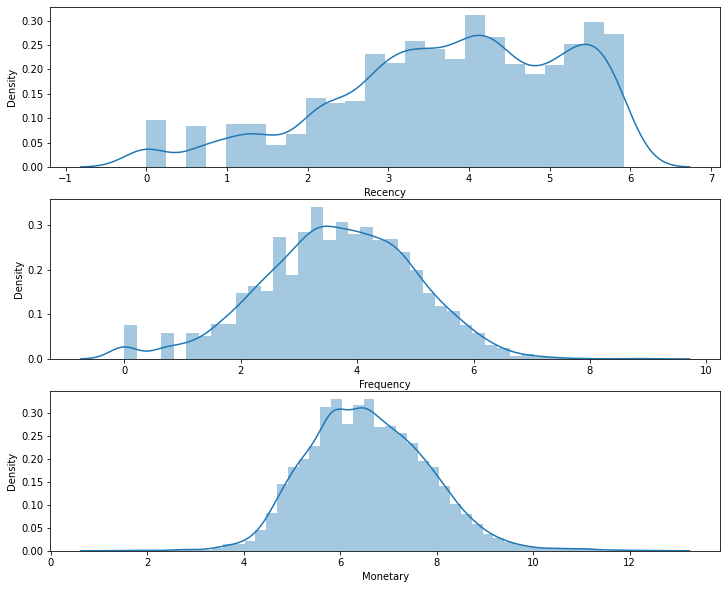

In [33]:

plt.figure(figsize=(12,10))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(data_norm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(data_norm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(data_norm['Monetary'])

# Show the plot
plt.show()

In [34]:
from sklearn.cluster import KMeans

In [35]:
sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data_norm)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

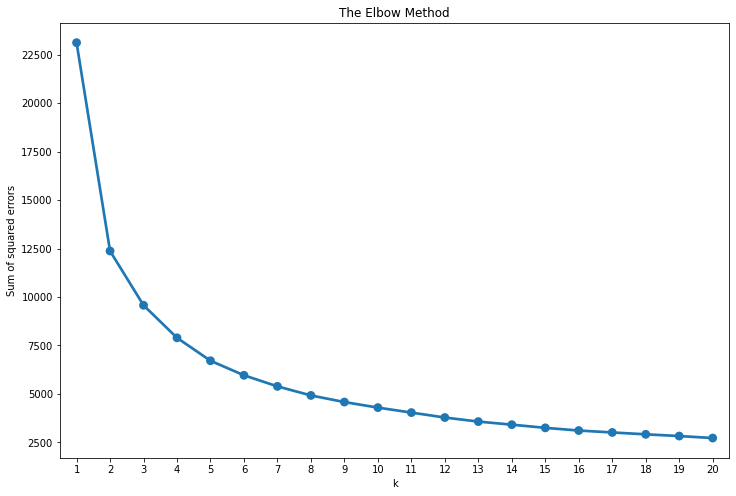

In [36]:
plt.figure(figsize=(12,8))

plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [37]:
kmeans = KMeans(n_clusters=3, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

In [38]:
# Create a cluster label column in the original DataFrame
data_norm_k3 = data_norm.assign(Cluster = cluster_labels)
data_k3 = raw_data.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k3 = data_k3.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'Monetary': ['mean', 'count'],}).round(0)

summary_k3

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          11.0     241.0   5587.0   984
1         175.0      15.0    302.0  1501
2          69.0      69.0   1226.0  1818

In [39]:

kmeans = KMeans(n_clusters=4, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

In [40]:
# Create a cluster label column in the original DataFrame
data_norm_k4 = data_norm.assign(Cluster = cluster_labels)
data_k4 = raw_data.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k4 = data_k4.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'Monetary': ['mean', 'count'],}).round(0)

summary_k4

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         199.0      16.0    319.0  1308
1          83.0      88.0   1616.0  1345
2          24.0      29.0    467.0   810
3          10.0     263.0   6205.0   840

In [41]:
display(summary_k3)
display(summary_k4)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          11.0     241.0   5587.0   984
1         175.0      15.0    302.0  1501
2          69.0      69.0   1226.0  1818

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         199.0      16.0    319.0  1308
1          83.0      88.0   1616.0  1345
2          24.0      29.0    467.0   810
3          10.0     263.0   6205.0   840

In [42]:
data.head()

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Segement,RFM_Score
0,12346,325,1,77183.60,1,1,4,114,6
1,12347,2,182,4310.00,4,4,4,444,12
2,12348,75,31,1797.24,2,2,4,224,8
3,12349,18,73,1757.55,3,3,4,334,10
4,12350,310,17,334.40,1,1,2,112,4


In [43]:
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Segement,RFM_Score
0,12346,325,1,77183.60,1,1,4,114,6
1,12347,2,182,4310.00,4,4,4,444,12
2,12348,75,31,1797.24,2,2,4,224,8
3,12349,18,73,1757.55,3,3,4,334,10
4,12350,310,17,334.40,1,1,2,112,4


In [44]:
data_norm_k4.index = data['CustomerID'].astype(int)

In [45]:
data_norm_k4.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,5.783825,0.000000,11.253942,1
12347,0.693147,5.204007,8.368693,3
12348,4.317488,3.433987,7.494007,1
12349,2.890372,4.290459,7.471676,1
12350,5.736572,2.833213,5.812338,0


In [46]:
#Melt the data into along format so RFM values and metric names are stored in 1 column each
data_melt = pd.melt(data_norm_k4.reset_index(),
                    id_vars=['CustomerID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'Monetary'],
                    var_name='Attribute',
                    value_name='Value')

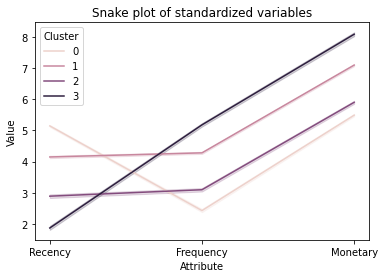

In [47]:
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=data_melt)

In [48]:
data_k4.index = data['CustomerID'].astype(int)
data_k4.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,325,1,77183.60,1
12347,2,182,4310.00,3
12348,75,31,1797.24,1
12349,18,73,1757.55,1
12350,310,17,334.40,0


In [49]:
raw_data.index = data['CustomerID'].astype(int)
raw_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,18,73,1757.55
12350,310,17,334.40


In [50]:
cluster_avg = data_k4.groupby(['Cluster']).mean()
population_avg = raw_data.head().mean()

In [51]:
cluster_avg

,Recency,Frequency,Monetary
Cluster,,,
0,199.379969,15.883028,318.667944
1,82.515242,88.498141,1616.146054
2,23.853086,29.071605,466.504765
3,9.834524,262.984524,6205.031810


In [52]:
population_avg

Recency        146.000
Frequency       60.800
Monetary     17076.558
dtype: float64

In [53]:
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,0.37,-0.74,-0.98
1,-0.43,0.46,-0.91
2,-0.84,-0.52,-0.97
3,-0.93,3.33,-0.64


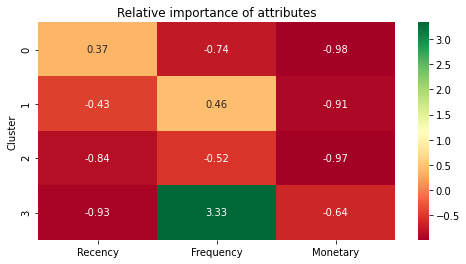

In [54]:
# Plot heatmap
plt.figure(figsize=(8, 4))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()